In [1]:
import sys
sys.path.append('library');

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt

datagen=ImageDataGenerator(
    rescale=1./255,
    rotation_range = 15,
    width_shift_range= 0.10,
    height_shift_range= 0.10,
    horizontal_flip=True,
    shear_range=2,
    zoom_range = [0.5, 1.5],
    validation_split=0.25 # 25%
)

batch_size=32;
basedir='/mnt/boveda/DATASETs/PATIENT-IMAGES/patient_people';# tow inside directories
data_gen_entrenamiento = datagen.flow_from_directory(   basedir, 
                                                        target_size=(224,224),
                                                        batch_size=batch_size,
                                                        shuffle=True,
                                                        subset='training'
                                                        );
data_gen_validacion = datagen.flow_from_directory(      basedir, 
                                                        target_size=(224,224),
                                                        batch_size=batch_size,
                                                        shuffle=True,
                                                        subset='validation'
                                                        );



Found 252 images belonging to 2 classes.
Found 84 images belonging to 2 classes.


# Mostrando algunos datos


N: 8
batch_size: 32


/usr/lib/python3/dist-packages/matplotlib/text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


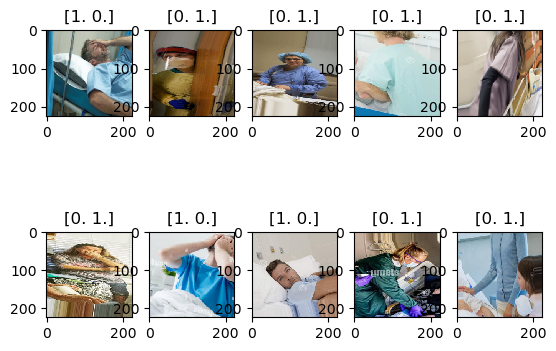

In [2]:
# Number of batchs
number_of_batchs=len(data_gen_entrenamiento);
# tuple-2 : data_gen_entrenamiento[n]=(image,label)
print("N:",number_of_batchs)
print("batch_size:",batch_size)
for imagen, etiqueta in data_gen_entrenamiento:
    for i in range(10):
        plt.subplot(2,5,i+1)
        plt.title(etiqueta[i])
        plt.imshow(imagen[i])
    break;
plt.show()


# Creando el modelo de transfer learning usando keras

In [3]:

import tensorflow as tf
import lib_model_patient_people as mpp

checkpoint_path='modelo.h5';
modelo=mpp.load_model_patient_people(checkpoint_path);
modelo.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


# Compilando y entrenando

In [8]:

# compilando
modelo.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Create a callback that saves the model's weights

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 monitor='val_accuracy', 
                                                 save_best_only=True,
                                                 verbose=1)


EPOCAS=100;
historical = modelo.fit(
    data_gen_entrenamiento, 
    steps_per_epoch=int(252.0/batch_size),
    epochs=EPOCAS, 
    validation_data=data_gen_validacion,
    callbacks=[cp_callback]
)

Epoch 1/100
7/7 [==============================] - 8s 996ms/step - loss: 0.4510 - accuracy: 0.7918 - val_loss: 0.5942 - val_accuracy: 0.6667

Epoch 00001: val_accuracy improved from -inf to 0.66667, saving model to modelo.h5
Epoch 2/100
7/7 [==============================] - 6s 902ms/step - loss: 0.3990 - accuracy: 0.8221 - val_loss: 0.5476 - val_accuracy: 0.7738

Epoch 00002: val_accuracy improved from 0.66667 to 0.77381, saving model to modelo.h5
Epoch 3/100
7/7 [==============================] - 6s 919ms/step - loss: 0.3112 - accuracy: 0.8744 - val_loss: 0.4489 - val_accuracy: 0.7738

Epoch 00003: val_accuracy did not improve from 0.77381
Epoch 4/100
7/7 [==============================] - 6s 915ms/step - loss: 0.3588 - accuracy: 0.8477 - val_loss: 0.4017 - val_accuracy: 0.8214

Epoch 00004: val_accuracy improved from 0.77381 to 0.82143, saving model to modelo.h5
Epoch 5/100
7/7 [==============================] - 6s 920ms/step - loss: 0.3219 - accuracy: 0.8573 - val_loss: 0.4208 - va

# Estadisticas

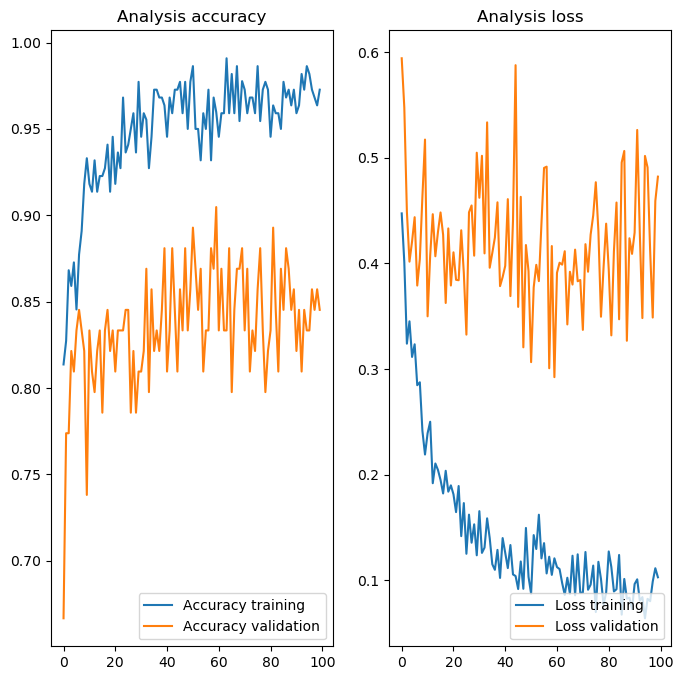

In [10]:
acc      = historical.history['accuracy'];
val_acc  = historical.history['val_accuracy'];
loss     = historical.history['loss'];
val_loss = historical.history['val_loss'];

rango_epocas=range(EPOCAS);

plt.figure(figsize=(8,8))
#
plt.subplot(1,2,1)
plt.plot(rango_epocas,    acc,label='Accuracy training')
plt.plot(rango_epocas,val_acc,label='Accuracy validation')
plt.legend(loc='lower right')
plt.title('Analysis accuracy')
#
plt.subplot(1,2,2)
plt.plot(rango_epocas,    loss,label='Loss training')
plt.plot(rango_epocas,val_loss,label='Loss validation')
plt.legend(loc='lower right')
plt.title('Analysis loss')
#
plt.show()